In [1]:
#%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

# 過去データの入手

In [2]:
df_kstart = pd.read_csv("data/ks-projects-201801.csv", encoding="utf-8")

display(df_kstart.head())
display(df_kstart["state"].value_counts())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# 基礎集計、グラフ化

*   ID: internal kickstarter id
*   name: name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or films.
*   category: category
*   main_category: category of campaign
*   currency: currency used to support
*   deadline: deadline for crowdfunding
*   goal: fundraising goal - The funding goal is the amount of money that a creator needs to complete their project.
*   launched: date launched
*   pledged: amount pledged by "crowd"
*   state: Current condition the project is in
*   backers: number of backers
*   country: country pledged from
*   usd pledged: amount of money pledged
*   usd_goal_real: Goal amount in USD

## データ成形
**ID**, **name** は固有値なので除外<br>
**pledged**, **usdpledged**, **usd_pledged_real** は結果なので除外<br>
**period** = **deadline** - **launched** を追加する (day)<br>
今回は成功失敗の二項分類なので **state**.successful, failed 以外は除く

In [3]:
def preprocess(df):
  # success, failed の行のみ適用する
  df = df[(df["state"] == "successful") | (df["state"] == "failed")]
  # 開催期間を説明変数に加える
  df["deadline"] = pd.to_datetime(df["deadline"], errors = "coerce")
  df["launched"] = pd.to_datetime(df["launched"], errors = "coerce")
  period = df["deadline"] - df["launched"]
  df["period"] = period.dt.days + (period.dt.seconds / 86400)
  # 不要な説明変数(固有値/結果)を除く
  df = df.drop(columns=["ID", "name", "pledged", "usd pledged", "usd_pledged_real"])
  
  return df

In [7]:
df_kstart = preprocess(df_kstart)
df_kstart = df_kstart[df_kstart["state"]!="live"]
df_kstart["state"] = df_kstart["state"]=="successful"
display(df_kstart.head())
df_kstart.info()

,category,main_category,currency,deadline,goal,launched,state,backers,country,usd_goal_real,period
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,False,0,GB,1533.95,58.491343
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,False,15,US,30000.00,59.802813
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,False,3,US,45000.00,44.985532
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,False,1,US,5000.00,29.858206
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,True,224,US,50000.00,34.431632


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 11 columns):
category         331675 non-null object
main_category    331675 non-null object
currency         331675 non-null object
deadline         331675 non-null datetime64[ns]
goal             331675 non-null float64
launched         331675 non-null datetime64[ns]
state            331675 non-null bool
backers          331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
period           331675 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 28.2+ MB


[goal], [usd_goal_real]の相関係数が高いので、どちらかは除外してもいいかもしれない
[backers], [period] は目的変数に相関がありそう



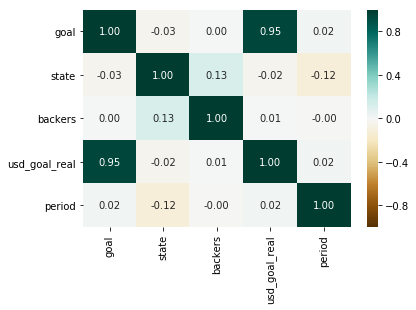

In [8]:
print("[goal], [usd_goal_real]の相関係数が高いので、どちらかは除外してもいいかもしれない")
print("[backers], [period] は目的変数に相関がありそう\n")
sns.heatmap(df_kstart.corr(), vmax=1, vmin=-1, center=0, annot=True, fmt=".2f", linecolor='white', cmap="BrBG")

## 類似情報の確認
main_category:category, country:currency この2組のデータには関係性がありそうなので確認する

In [9]:
from scipy.spatial.distance import cdist

def my_corr(df1, df2):
  """Input:df1->DataFrame, df2->DataFrame, Output:corr->DataFrame(df1とdf2の相関係数)"""
  # numpyに変換
  n_df1 = df1.T.values
  n_df2 = df2.T.values
  
  corr = (1 - cdist(n_df1, n_df2, metric="correlation"))
  # pd.DataFrameに変換
  return pd.DataFrame(corr, index=df1.columns, columns=df2.columns)

### [main_category] と [category] の関係

相関係数
関係性はありそうなのでもっと詳しく見ていく



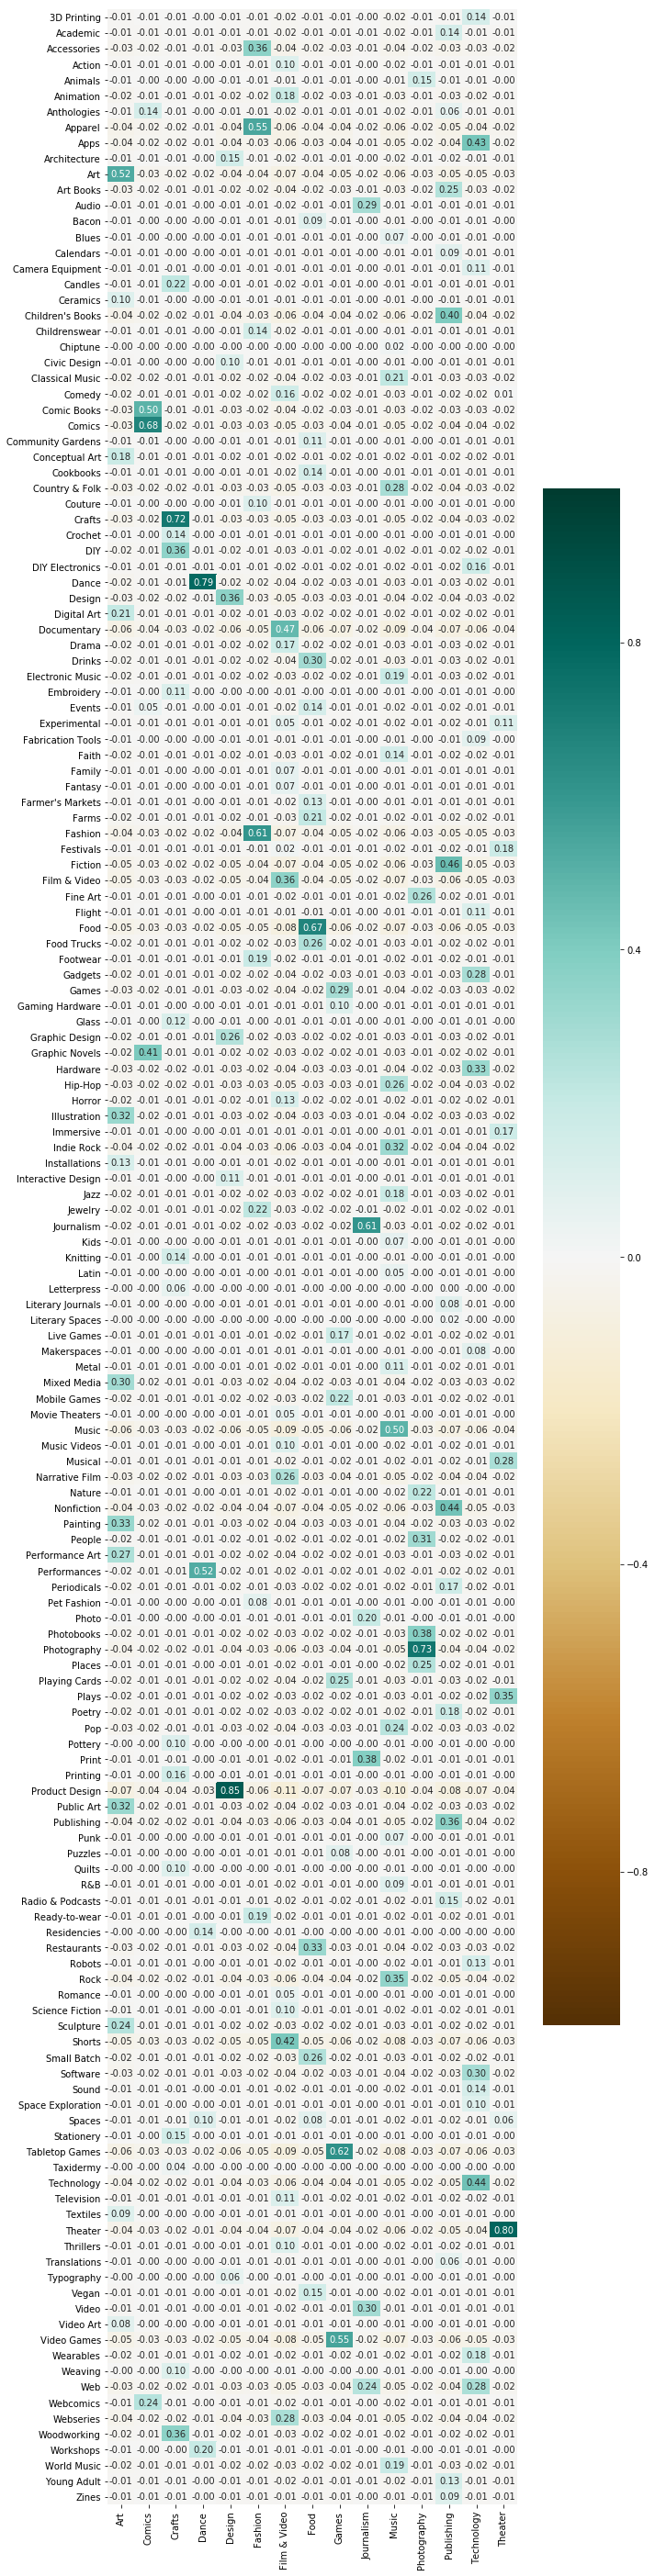

In [10]:
main_category = pd.get_dummies(df_kstart["main_category"]).fillna(0)
category = pd.get_dummies(df_kstart["category"]).fillna(0)
corr1 = my_corr(category, main_category)
plt.figure(figsize=(10, 50))
print("相関係数")
sns.heatmap(corr1, vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")
print("関係性はありそうなのでもっと詳しく見ていく\n")

In [11]:
unique_category = df_kstart.groupby("category")["main_category"]

print("対応表")
print("ほとんどの category が main_category を一意に定めることができそう\n")
print(unique_category.unique())

norm_unique_category = unique_category.value_counts(normalize=True)
unique_category = unique_category.value_counts()
#display(norm_unique_category.unstack(fill_value=0))

対応表
ほとんどの category が main_category を一意に定めることができそう

category
3D Printing                                        [Technology]
Academic                                           [Publishing]
Accessories                                           [Fashion]
Action                                           [Film & Video]
Animals                                           [Photography]
Animation                                        [Film & Video]
Anthologies                                [Comics, Publishing]
Apparel                                               [Fashion]
Apps                                               [Technology]
Architecture                                           [Design]
Art                                                       [Art]
Art Books                                          [Publishing]
Audio                                              [Journalism]
Bacon                                                    [Food]
Blues                                       

In [12]:
index1 = unique_category[norm_unique_category < 1].keys()
multi_category = unique_category[index1]
print("main_category を一意に定めることができない category\n")
print(multi_category)
print("\n総数: {}".format(multi_category.sum()))
print("割合: {:.2f}%".format(multi_category.sum() / len(df_kstart) * 100))
print("約97%の category が一意に main_category を定めることができる\nmain_category :除外候補")
#print(unique_category.unique()[unique_category.nunique()>1]).keys()
#unique_category.value_counts()

main_category を一意に定めることができない category

category      main_category
Anthologies   Comics            386
              Publishing        351
Comedy        Film & Video     1893
              Theater            92
              Publishing         66
              Music              17
Events        Food              567
              Comics            140
Experimental  Film & Video      480
              Theater           342
Festivals     Theater           512
              Film & Video      263
Letterpress   Crafts             36
              Publishing         10
Spaces        Food              383
              Theater           194
              Dance             178
Web           Technology       3237
              Journalism       1072
Name: main_category, dtype: int64

総数: 10219
割合: 3.08%
約97%の category が一意に main_category を定めることができる
main_category :除外候補


### [country] と [currency] の関係

相関係数
country から currency を一意に定めることができそうだ



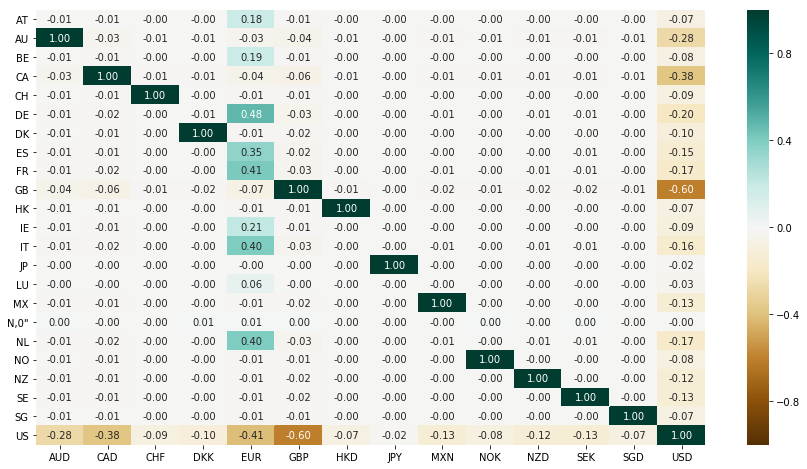

In [13]:
country = pd.get_dummies(df_kstart["country"]).fillna(0)
currency = pd.get_dummies(df_kstart["currency"]).fillna(0)
corr2 = my_corr(country, currency)
plt.figure(figsize=(15, 8))
print("相関係数")
print("country から currency を一意に定めることができそうだ\n")
sns.heatmap(corr2, vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")

In [14]:
unique_country = df_kstart.groupby("country")["currency"]

print("対応表")
print("N,0 を除けば country から currency が決まる\n")
print(unique_country.unique())

norm_unique_country = unique_country.value_counts(normalize=True)
unique_country = unique_country.value_counts()
#norm_unique_country.unstack(fill_value=0)

対応表
N,0 を除けば country から currency が決まる

country
AT                                         [EUR]
AU                                         [AUD]
BE                                         [EUR]
CA                                         [CAD]
CH                                         [CHF]
DE                                         [EUR]
DK                                         [DKK]
ES                                         [EUR]
FR                                         [EUR]
GB                                         [GBP]
HK                                         [HKD]
IE                                         [EUR]
IT                                         [EUR]
JP                                         [JPY]
LU                                         [EUR]
MX                                         [MXN]
N,0"    [USD, GBP, CAD, EUR, NOK, DKK, SEK, AUD]
NL                                         [EUR]
NO                                         [NOK]
NZ                    

In [15]:
index2 = unique_country[norm_unique_country < 1].keys()
multi_country = unique_country[index2]
print("N,0 の詳細\n")
print(multi_country)
print("\n総数: {}".format(multi_country.sum()))
print("割合: {:.2f}%".format(multi_country.sum() / len(df_kstart) * 100))
print("約100%の country が一意に currency を定めることができる\ncurrency :除外候補")
#print(unique_category.unique()[unique_category.nunique()>1]).keys()
#unique_category.value_counts()

N,0 の詳細

country  currency
N,0"     USD         151
         GBP          22
         EUR          21
         AUD           5
         CAD           5
         DKK           3
         NOK           2
         SEK           1
Name: currency, dtype: int64

総数: 210
割合: 0.06%
約100%の country が一意に currency を定めることができる
currency :除外候補


## 日付について
開始/終了した年月日によって成否が変わるかもしれないので確認


In [16]:
def get_date_dummies(df, columns):
  for column in columns:
    df[column+"_year"] = df[column].dt.year
    df[column+"_month"] = df[column].dt.month
    df[column+"_day"] = df[column].dt.day
    df = df.drop(columns=column)
  return df

def drop_date_dummies(df, columns):
  for column in columns:
    df = df.drop(columns=[column+"_year", column+"_month", column+"_day"])
  return df

In [17]:
df_kstart = get_date_dummies(df_kstart, columns=["deadline", "launched"])

[deadline_year],[launched_year] に関係はありそうだが、過去の年データは予測に不要なので考慮しない
[deadline],[launched] :除外候補



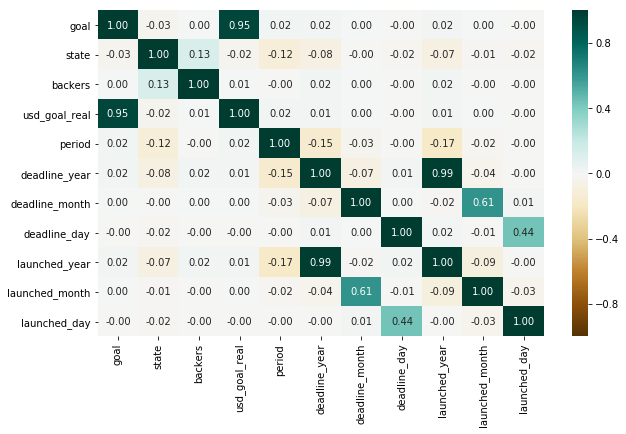

In [18]:
print("[deadline_year],[launched_year] に関係はありそうだが、過去の年データは予測に不要なので考慮しない")
print("[deadline],[launched] :除外候補\n")
plt.figure(figsize=(10, 6))
sns.heatmap(df_kstart.corr(), vmax=1, vmin=-1, center=0, annot=True, fmt='.2f', linecolor='white', cmap="BrBG")

# 特徴量の設計・抽出

## データの除外
除外候補の [country], [main_category], [deadline], [launched] を除外

In [19]:
df_kstart = df_kstart.drop(columns=["usd_goal_real", "main_category", "currency"])
df_kstart = drop_date_dummies(df_kstart, columns=["deadline", "launched"])

In [20]:
df_kstart = pd.get_dummies(df_kstart, columns=["category"]).fillna(0)
df_kstart = pd.get_dummies(df_kstart, columns=["country"]).fillna(0)

In [21]:
df_kstart.head(10)

,goal,state,backers,period,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,1000.0,False,0,58.491343,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,False,15,59.802813,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,False,3,44.985532,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,False,1,29.858206,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,True,224,34.431632,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1000.0,True,16,19.228657,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,25000.0,False,40,44.163056,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,2500.0,False,0,29.236377,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,12500.0,True,100,29.720162,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,5000.0,False,0,29.283449,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# データの前処理


## 標準化
backer, goal, period を標準化

In [22]:
def standardization(x):
    return (x - x.mean()) / x.std()

In [23]:
df_kstart['backers'] = standardization(df_kstart['backers'])
df_kstart['goal'] = standardization(df_kstart['goal'])
df_kstart['period'] = standardization(df_kstart['period'])

In [24]:
df_kstart.head(10)

,goal,state,backers,period,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,...,country_JP,country_LU,country_MX,"country_N,0""",country_NL,country_NO,country_NZ,country_SE,country_SG,country_US
0,-0.038689,False,-0.120549,1.972900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.012748,False,-0.105012,2.075975,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.000669,False,-0.117442,0.911405,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,-0.035111,False,-0.119513,-0.277534,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0.005142,True,0.111472,0.081916,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,-0.038689,True,-0.103976,-1.112968,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,-0.017221,False,-0.079117,0.846762,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,-0.037348,False,-0.120549,-0.326407,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,-0.028402,True,-0.016968,-0.288384,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,-0.035111,False,-0.120549,-0.322707,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# モデルの検討
精度を求めるのでNNで実装してみる

## 評価基準決定
accuracy

In [25]:
X = df_kstart.drop(columns=["state"]).values
y = df_kstart["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [26]:
print(X_train.shape)
print(y_train.shape)

(265340, 185)
(265340,)


In [29]:
import time
import NN_lib as lib

In [30]:
y_train = lib.bool_to_onehot(y_train)
y_test = lib.bool_to_onehot(y_test)

In [31]:
class MLP(lib.NN):
    def __init__(self, num_class, act_func, in_size, hid_size):#dropout=True):
        self.fc1 = lib.FullConnectedLayer(in_size, hid_size)
        self.bn1 = lib.BatchNormalization(hid_size)
        #self.fc2 = lib.FullConnectedLayer(140, 140)
        #self.bn2 = lib.BatchNormalization(140)
        self.fc2 = lib.FullConnectedLayer(hid_size, num_class)
        
    @property
    def forward(self):
        return (
            self.fc1, self.bn1, act_func,
            self.fc2)#, self.bn2, act_func,
            #self.fc3
        #)

    def __call__(self, x):
        for f in self.forward:
            x = f(x)
        return x
        
    def backward(self, d):
        for f in reversed(self.forward):
            d = f.backward(d)

# モデルの評価

In [34]:
epoch = 20
batch_size = 128
lr = 0.1

#act_func = sigmoid()
act_func = lib.Relu()
optimizer = lib.Adam(lr=lr)
model = MLP(2, act_func=act_func, in_size=185, hid_size=200)

print(
    "{0:>7} | {1:>14} | {2:>14} | {3:>14} | {4:>14} | {5:>14}".format(
        "epoch", "train_loss", "train_accuracy", "test_loss", "test_accuracy", "elapsed_time"
        )
    )

N = len(X_train)
start = time.time()

for i in range(epoch):
    if i in set([5,10,15]):
        lr *= 0.1
        optimizer.lr_decay(lr=lr)
    p = np.random.permutation(len(X_train))
    X_train = X_train[p]
    y_train = y_train[p]
    for j in range(N // batch_size):
        X_iter = X_train[j * batch_size : (j+1) * batch_size]
        y_iter = y_train[j * batch_size : (j+1) * batch_size]
        y = model(X_iter)
        y, delta = lib.softmax_closs_entropy(y, y_iter)
        model.backward(delta)
        model.update(optimizer)

    train = model(X_train)
    test = model(X_test)
    train_loss, train_accuracy = lib.loss_and_accracy(train, y_train)
    test_loss, test_accuracy = lib.loss_and_accracy(test, y_test)
    elapsed_time = time.time() - start

    print(
        "{0:>7} | {1:14.5f} | {2:14.5f} | {3:14.5f} | {4:14.5f} | {5:14.5f}".format(
            i + 1, train_loss, train_accuracy, test_loss, test_accuracy, elapsed_time
            )
        )

  epoch |     train_loss | train_accuracy |      test_loss |  test_accuracy |   elapsed_time
      1 |        0.61135 |        0.66898 |        0.60988 |        0.66978 |        8.82418
      2 |        0.63478 |        0.63967 |        0.63436 |        0.63990 |       17.03318
      3 |        0.67622 |        0.59543 |        0.67531 |        0.59890 |       25.20367
      4 |        0.66120 |        0.59474 |        0.66077 |        0.59739 |       33.65619
      5 |        0.63135 |        0.65751 |        0.63191 |        0.65750 |       42.00094
      6 |        0.63022 |        0.65319 |        0.63011 |        0.65198 |       50.39347
      7 |        0.61115 |        0.66880 |        0.61120 |        0.66808 |       58.82871
      8 |        0.61539 |        0.65804 |        0.61556 |        0.65765 |       67.23765
      9 |        0.59882 |        0.68333 |        0.59865 |        0.68309 |       75.67448
     10 |        0.60804 |        0.66731 |        0.60804 |        0.

# 結果から検討

約80%の精度となった。
Weight decay, dropout等を実装すれば少しは精度が向上するかもしれない。
飛躍的に精度を上げるには、根本的にデータの関係を見直すか、性能の高いパソコンでNNを広くするか...
と、考える。